In [1]:
%matplotlib inline
! pip install --user spectres
! pip install --user specutils

You should consider upgrading via the 'C:\Users\cylam\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\cylam\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
from pkg_resources import resource_filename
from spectres import spectres

(Something about stellar spectra here.)

In [3]:
# Load the data files for the F2 and A9 stars at solar metallicity
# Data were downloaded from https://zenodo.org/record/344471
f2_star_filepath = resource_filename('desihigh','dat/BinaryStarsSpec/spec-3683-55178-0798.FITS')
a9_star_filepath = resource_filename('desihigh','dat/BinaryStarsSpec/spec-7256-56658-0881.FITS')

f2_star_fits = fits.open(f2_star_filepath)
a9_star_fits = fits.open(a9_star_filepath)

# Masking the mutual wavelegnth coverage
log_wave = np.arange(3.5575, 4.0154, 0.0001)
wave = 10.**log_wave
f2_mask = np.in1d(f2_star_fits[1].data['loglam'], log_wave.astype('float32'))
a9_mask = np.in1d(a9_star_fits[1].data['loglam'], log_wave.astype('float32'))

f2_flux = f2_star_fits[1].data['flux'][f2_mask]
a9_flux = a9_star_fits[1].data['flux'][a9_mask]

# Get the combined flux
total_flux = f2_flux + a9_flux

Text(0.5, 0, 'Wavelength / $\\AA$')

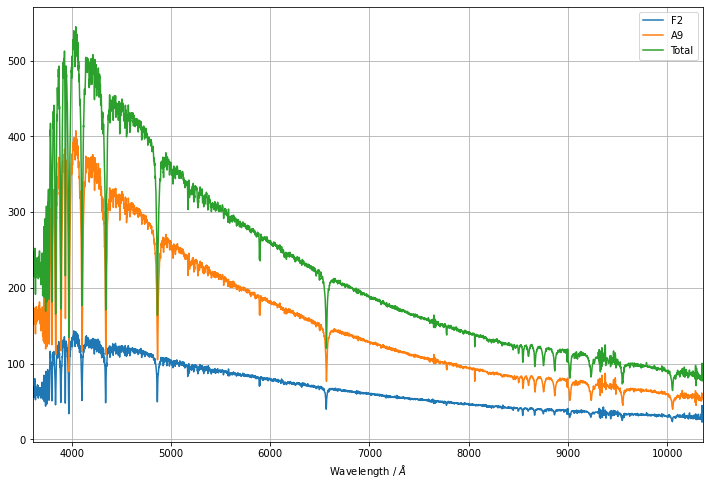

In [4]:
plt.figure(1, figsize=(12, 8))
plt.plot(wave, f2_flux, label='F2')
plt.plot(wave, a9_flux, label='A9')
plt.plot(wave, total_flux, label='Total')
plt.legend()
plt.grid()
plt.xlim(min(10.**(log_wave)), max(10.**(log_wave)))
plt.xlabel(r'Wavelength / $\AA$')

(Something about binary stars and circular orbits here. Kepler laws)
(Link to refresh doppler shift.)
(Qualitatively compare Redshift and RV)

In [5]:
# Compute the RV as a function of phase here

# https://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt
# F2 - 1.46 solar mass
# A9 - 1.75 solar mass



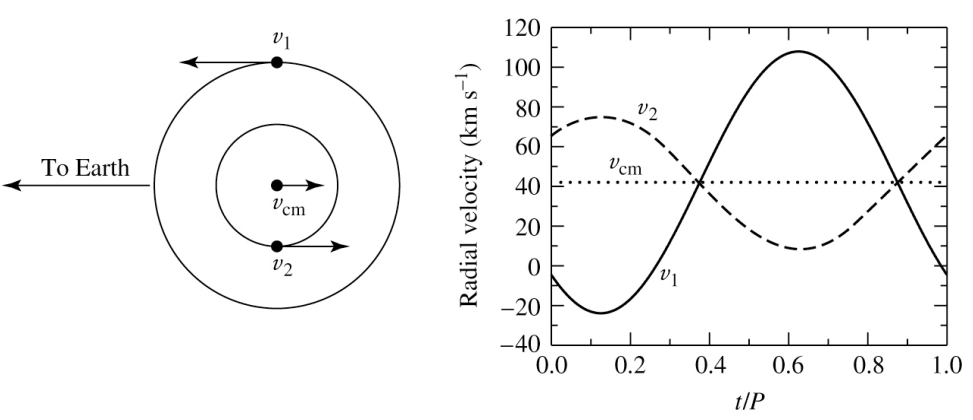
Image from http://burro.case.edu/Academics/Astr221/StarProp/speclipse.html

In [6]:
from astropy import constants
from astropy import units

M1 = 1.75 * constants.GM_sun # solar mass
M2 = 1.46 * constants.GM_sun # solar mass

a = 0.01 * constants.au # AU

# Kepler third law
Period = 2. * np.pi * np.sqrt(a**3. / (M1 + M2))

print('The orbital period between the two stars is {}.'.format(Period.to('day')))

The orbital period between the two stars is 0.20386652054342558 d.


(If the system is perfectly side-on - largest possible RV)
(If the sytem is perpendicular to us - no RV)
(If the system is inclined to us - somewhere in the middle)

In [7]:
# velocity of the center of mass of the system
v_offset = 17.1 * units.km / units.s

# v1 / v2
v1_d_v2 = M2 / M1
# v1 + v2
v1_p_v2 = a * 2. * np.pi / Period

v2 = v1_p_v2 / (v1_d_v2 + 1)
v1 = v1_p_v2 - v2

print('The maximum velocity (from the offset) of the A9 star is {}.'.format(v1.to('km/s')))
print('The maximum velocity (from the offset) of the F2 star is {}.'.format(v2.to('km/s')))

The maximum velocity (from the offset) of the A9 star is 242.71323040939433 km / s.
The maximum velocity (from the offset) of the F2 star is 290.9233926140001 km / s.


Text(0, 0.5, 'km / s')

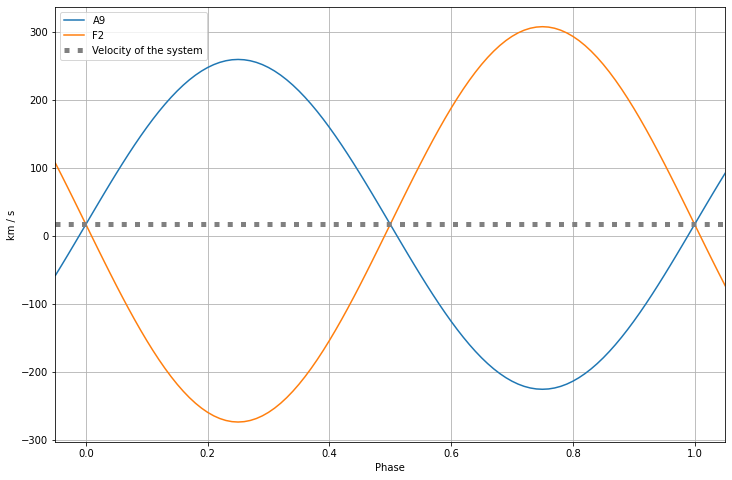

In [8]:
phase = np.arange(-0.05, 1.06, 0.01)

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.plot(phase, np.sin(phase*2*np.pi)*v1.to('km/s') + v_offset, label='A9')
ax.plot(phase, np.sin(phase*2*np.pi-np.pi)*v2.to('km/s') + v_offset, label='F2')
ax.hlines(v_offset.value, -0.05, 1.05, ls=':', lw=5, color='grey', label='Velocity of the system')
ax.grid()
ax.legend()
ax.set_xlim(-0.05, 1.05)
ax.set_xlabel('Phase')
ax.set_ylabel('km / s')

(Now we simulate the spectra observed at different phases.)

In [9]:
phase_obs = np.linspace(0.02, 0.95, 11)
v1_obs = np.sin(phase_obs*2*np.pi)*v1.to('km/s') + v_offset
v2_obs = np.sin(phase_obs*2*np.pi-np.pi)*v2.to('km/s') + v_offset

f2_obs = []
a9_obs = []
for _v1, _v2 in zip(v1_obs, v2_obs):
    w1 = wave + wave * _v1 / constants.c.to('km/s')
    w2 = wave + wave * _v2 / constants.c.to('km/s')
    f2_obs.append(spectres(wave, w1, f2_flux, verbose=False))
    a9_obs.append(spectres(wave, w2, a9_flux, verbose=False))


Text(0, 0.5, 'Flux (with Arbitrary Offset)')

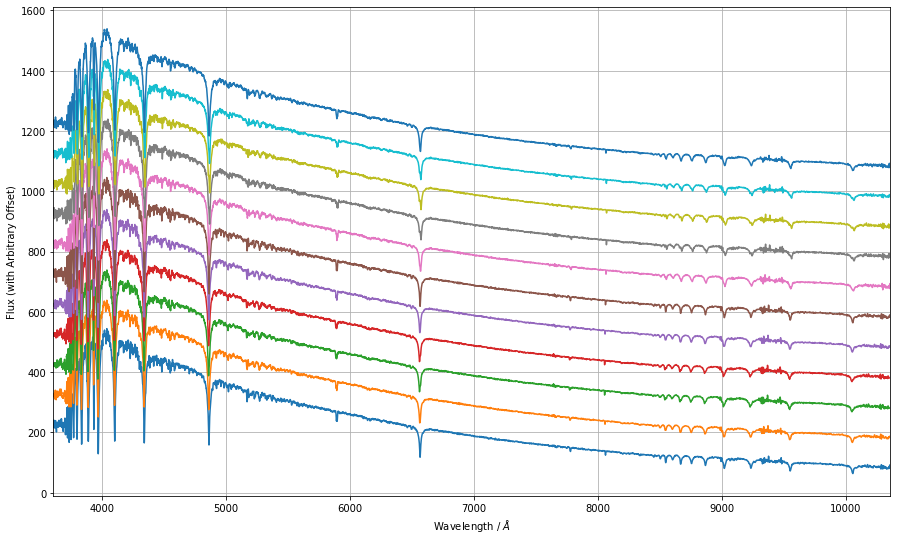

In [10]:
fig = plt.figure(figsize=(15, 9))
for i in range(len(f2_obs)):
    spec_sum = f2_obs[i] + a9_obs[i]
    plt.plot(wave, spec_sum + i * 100, label=str(phase_obs[i])[:5])

plt.xlim(min(wave), max(wave))
plt.grid()
plt.xlabel(r'Wavelength / $\AA$')
plt.ylabel('Flux (with Arbitrary Offset)')

Text(0.5, 1.0, 'H$\\beta$')

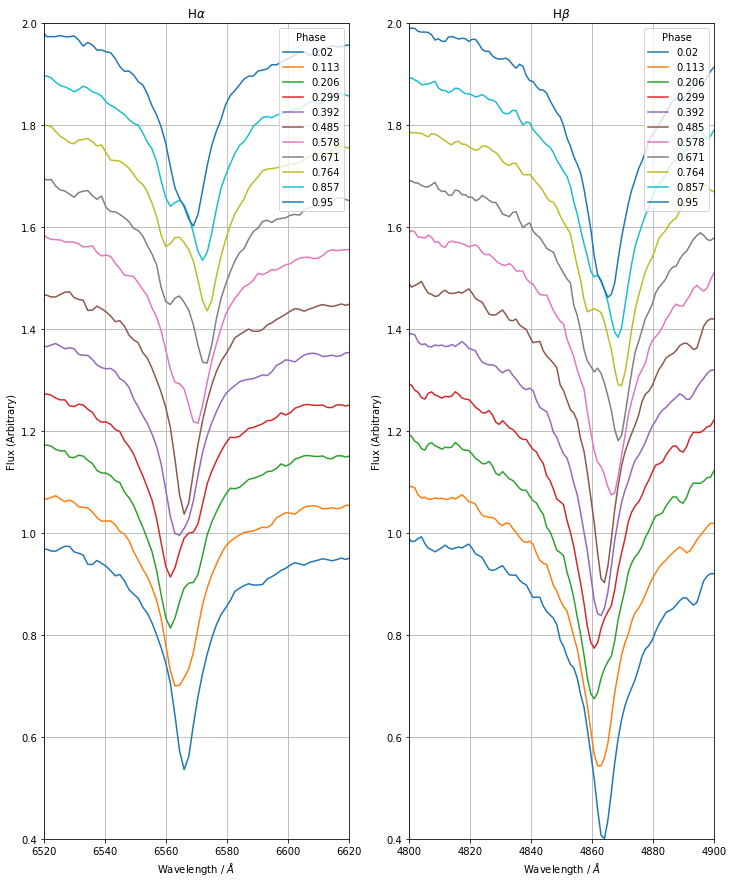

In [11]:
h_alpha_mask = (wave > 6500) & (wave < 6640)
h_beta_mask = (wave > 4780) & (wave < 4920)

fig = plt.figure(figsize=(12, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i in range(len(f2_obs)):
    spec_sum = f2_obs[i] + a9_obs[i]
    ax1.plot(wave, spec_sum / np.nanmax(spec_sum[h_alpha_mask]) + i / 10., label=str(phase_obs[i])[:5])
    ax2.plot(wave, spec_sum / np.nanmax(spec_sum[h_beta_mask]) + i / 10., label=str(phase_obs[i])[:5])


leg1 = ax1.legend(loc='upper right')
leg1.set_title('Phase')
ax1.set_xlim(6520, 6620)
ax1.set_ylim(0.4, 2.0)
ax1.grid()
ax1.set_xlabel(r'Wavelength / $\AA$')
ax1.set_ylabel('Flux (Arbitrary)')
ax1.set_title(r'H$\alpha$')

leg2 = ax2.legend(loc='upper right')
leg2.set_title('Phase')
ax2.set_xlim(4800, 4900)
ax2.set_ylim(0.4, 2.0)
ax2.grid()
ax2.set_xlabel(r'Wavelength / $\AA$')
ax2.set_ylabel('Flux (Arbitrary)')
ax2.set_title(r'H$\beta$')

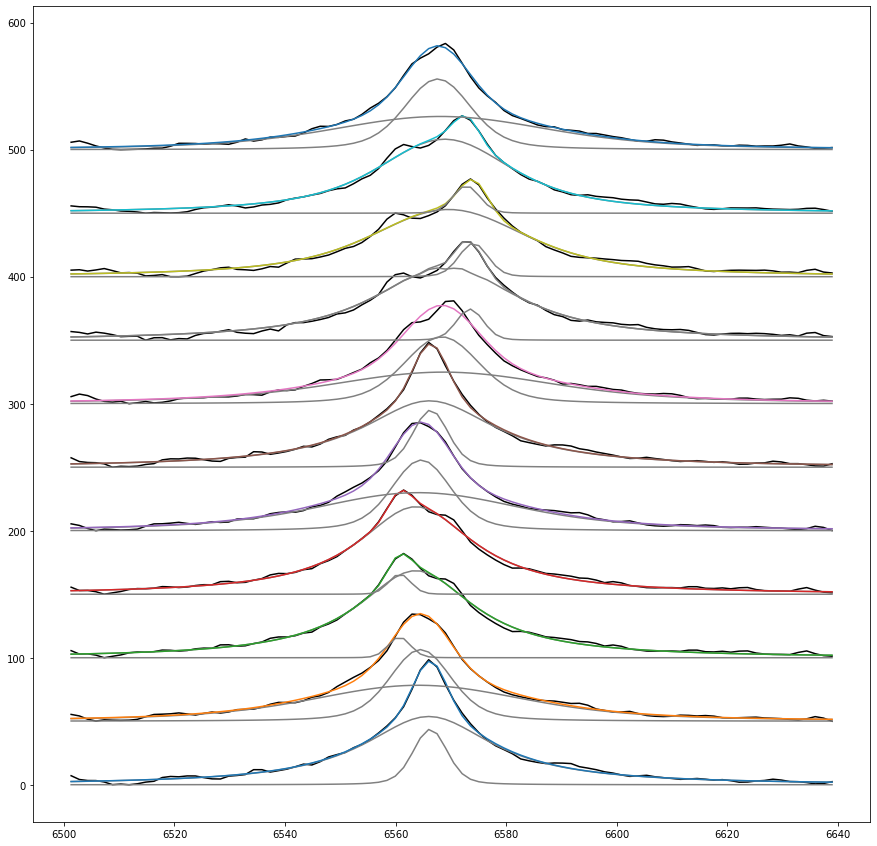

In [12]:
from astropy.modeling import models
from astropy.modeling import fitting
from astropy import units

from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines

plt.figure(figsize=(15, 15))
for i in range(len(f2_obs)):
    spec_sum = f2_obs[i] + a9_obs[i]
    
    left = spec_sum[h_alpha_mask][:10]
    wave_left = wave[h_alpha_mask][:10]
    right = spec_sum[h_alpha_mask][-10:]
    wave_right = wave[h_alpha_mask][-10:]

    coeff = np.polyfit(
        np.concatenate([wave_left, wave_right]),
        np.concatenate([left, right]),
        deg=1)
    continuum_linear = np.poly1d(coeff)

    _spectrum = spec_sum[h_alpha_mask] - continuum_linear(wave[h_alpha_mask])
    _spectrum = np.min(_spectrum) - _spectrum
    _spectrum = _spectrum - np.min(_spectrum)
    spectrum = Spectrum1D(
        flux=_spectrum*units.mgy,
        spectral_axis=wave[h_alpha_mask]*units.Angstrom)

    weights = np.sqrt(spec_sum[h_alpha_mask])

    gl_init = models.Voigt1D(
        amplitude_L=25.*units.mgy,
        x_0=6560*units.Angstrom,
        fwhm_L=2*units.Angstrom,
        fwhm_G=5*units.Angstrom,
        bounds={'amplitude_L': [1, 120]})
    gr_init = models.Voigt1D(
        amplitude_L=80.*units.mgy,
        x_0=6570*units.Angstrom,
        fwhm_L=2*units.Angstrom,
        fwhm_G=5*units.Angstrom,
        bounds={'amplitude_L': [1, 120]})
    gl_fit, gr_fit = fit_lines(
        spectrum,
        gl_init+gr_init,
        weights=1./weights,
        fitter=fitting.LevMarLSQFitter(),
        maxiter=10000)
    yl_fit = gl_fit(wave[h_alpha_mask]*units.Angstrom)
    yr_fit = gr_fit(wave[h_alpha_mask]*units.Angstrom)

    plt.plot(spectrum.spectral_axis, spectrum.flux.value + i*50, color='black')
    plt.plot(wave[h_alpha_mask], yl_fit.value + i*50, color='grey')
    plt.plot(wave[h_alpha_mask], yr_fit.value + i*50, color='grey')
    plt.plot(wave[h_alpha_mask], yl_fit.value + i*50 + yr_fit.value)


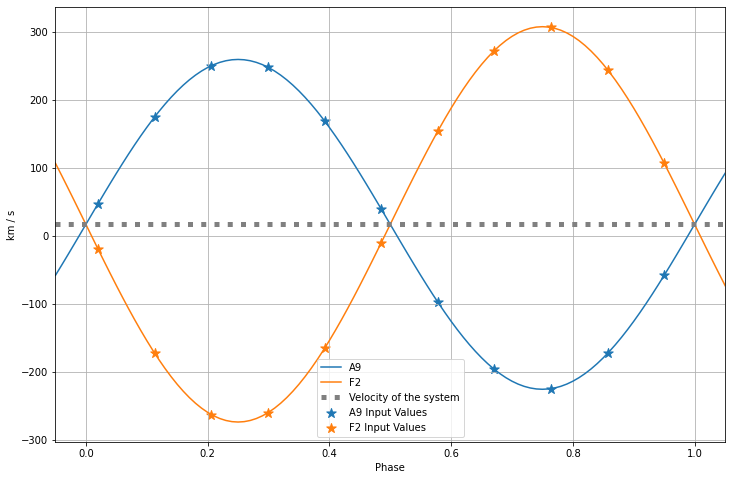

In [13]:
plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.plot(phase, np.sin(phase*2*np.pi)*v1.to('km/s') + v_offset, label='A9')
ax.plot(phase, np.sin(phase*2*np.pi-np.pi)*v2.to('km/s') + v_offset, label='F2')
ax.hlines(v_offset.value, -0.05, 1.05, ls=':', lw=5, color='grey', label='Velocity of the system')
ax.grid()
ax.set_xlim(-0.05, 1.05)
ax.set_xlabel('Phase')
ax.set_ylabel('km / s')
ax.scatter(phase_obs, v1_obs, s=100, marker='*', label='A9 Input Values')
ax.scatter(phase_obs, v2_obs, s=100, marker='*', label='F2 Input Values')
ax.legend()